This script performs a short preliminary analysis of the time series data at hand.

First section: visual inspection of all variables.

Second section: tests for stationarity, autocorrelation, and unit roots

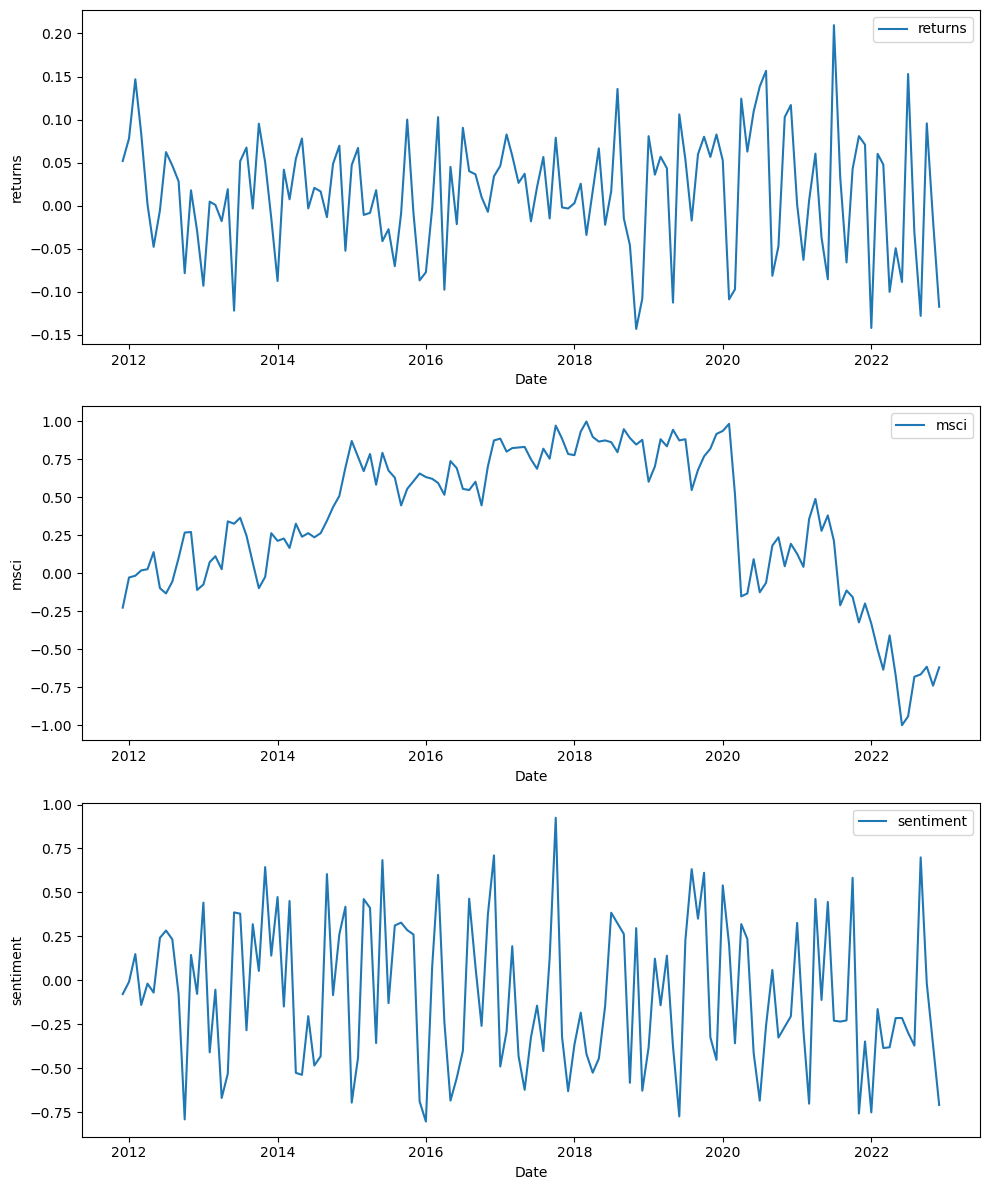

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import os as os


df = pd.read_csv('./tsdata/preprocessed_data.csv', index_col='Date', parse_dates=True)

#Plotting time series
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 4))
if num_variables == 1:
    axes = [axes]
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=f'{column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

From inspecting the graphs, we can clearly see non-stationary features from all variables under consideration, suggesting to difference/fitting and ARIMA model.

We can further test the hypothesis of stationarity by testing for unit roots using the Augemented Dickey fuller test.

In [9]:
def perform_adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic for {series.name}: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Critical Value ({key}): {value}')
    if result[1] < 0.05:
        print("Evidence against null hypothesis, data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root indicating it is non-stationary")

for column in df.columns:
    perform_adf_test(df[column])

ADF Statistic for returns: -9.878610437516176
p-value: 3.822903285345119e-17
Critical Value (1%): -3.481281802271349
Critical Value (5%): -2.883867891664528
Critical Value (10%): -2.5786771965503177
Evidence against null hypothesis, data has no unit root and is stationary
ADF Statistic for msci: -0.13087896968920637
p-value: 0.9462746836236037
Critical Value (1%): -3.482920063655088
Critical Value (5%): -2.884580323367261
Critical Value (10%): -2.5790575441750883
Weak evidence against null hypothesis, time series has a unit root indicating it is non-stationary
ADF Statistic for sentiment: -8.662810017458883
p-value: 4.771714643472277e-14
Critical Value (1%): -3.481281802271349
Critical Value (5%): -2.883867891664528
Critical Value (10%): -2.5786771965503177
Evidence against null hypothesis, data has no unit root and is stationary


As we could not reject the null hypothesis of an existence of a unit root for the MSCI time series, we perform differecing I(1).

In [10]:
df["msci"] = df["msci"].diff().dropna()
df = df.iloc[1:]

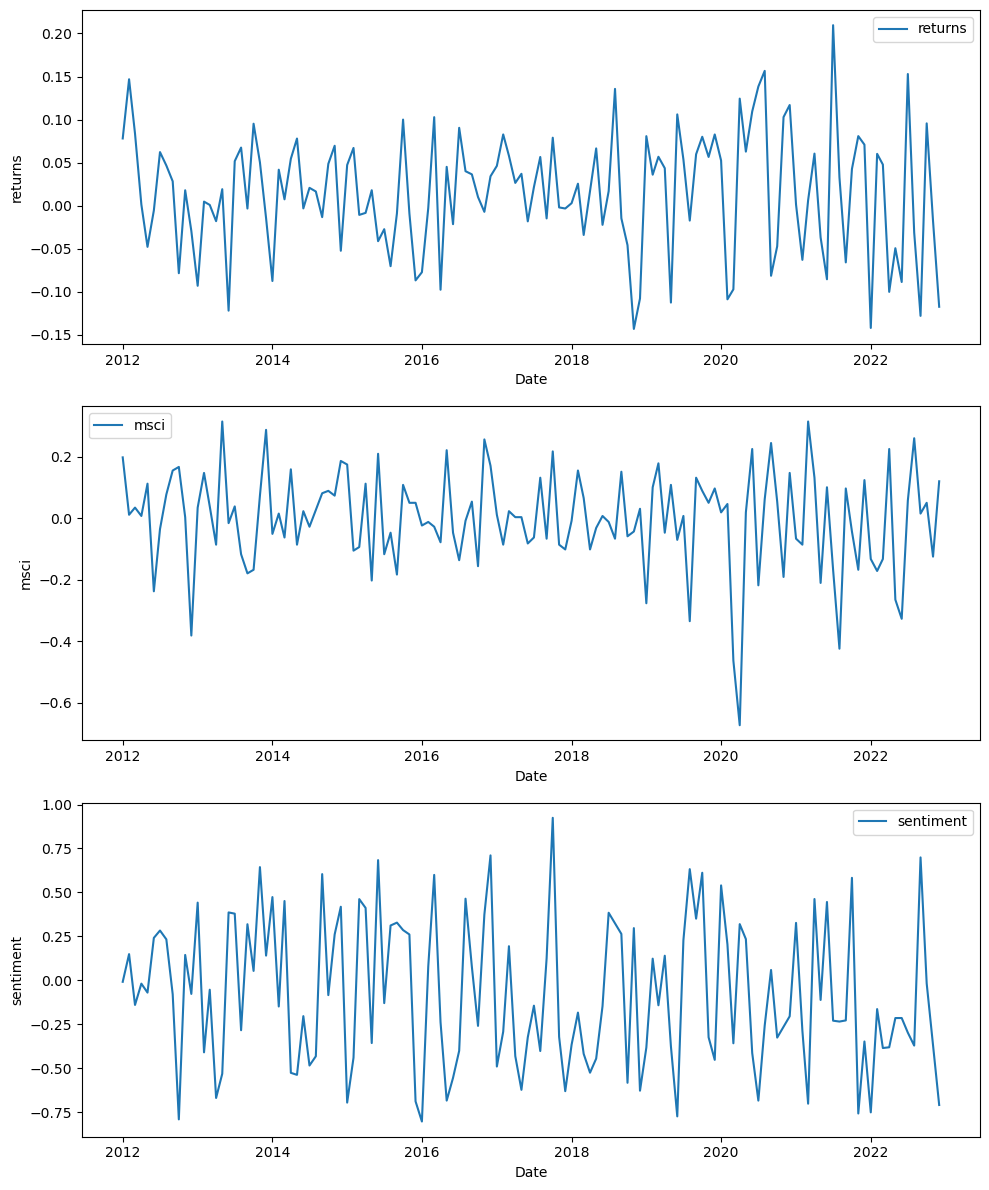

In [11]:
num_variables = len(df.columns)
fig, axes = plt.subplots(nrows=num_variables, ncols=1, figsize=(10, num_variables * 4))
if num_variables == 1:
    axes = [axes]
for ax, column in zip(axes, df.columns):
    ax.plot(df.index, df[column], label=f'{column}')
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

In [12]:
for column in df.columns:
    perform_adf_test(df[column])

ADF Statistic for returns: -10.146250239436894
p-value: 8.171422372872634e-18
Critical Value (1%): -3.4816817173418295
Critical Value (5%): -2.8840418343195267
Critical Value (10%): -2.578770059171598
Evidence against null hypothesis, data has no unit root and is stationary
ADF Statistic for msci: -7.137877542698443
p-value: 3.383743633380216e-10
Critical Value (1%): -3.482920063655088
Critical Value (5%): -2.884580323367261
Critical Value (10%): -2.5790575441750883
Evidence against null hypothesis, data has no unit root and is stationary
ADF Statistic for sentiment: -8.642660332886244
p-value: 5.373645175258619e-14
Critical Value (1%): -3.4816817173418295
Critical Value (5%): -2.8840418343195267
Critical Value (10%): -2.578770059171598
Evidence against null hypothesis, data has no unit root and is stationary


After a second round of visual inspection and ADF tests, we can consider all series to be stationary. We now can proceed to fitting an ARMA model.

In [13]:
df.to_csv("./tsdata/modeldata.csv")